In [8]:
!pip install keras==2.3.1

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import SVG
import os
#import tensorflow as tf

# from sklearn.pipeline import Pipeline
# from scipy import stats
# from sklearn.feature_selection import f_regression
# from scipy.stats import norm
# import statsmodels.api as sm
# import statsmodels.formula.api as sm
# from sklearn.linear_model import LinearRegression
# from sklearn.decomposition import PCA
# from sklearn.linear_model import Perceptron
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# !pip install pydot
# import pydot
print(keras.__version__)
%matplotlib inline

Using TensorFlow backend.


2.3.1


# 데이터 불러오기

In [2]:
total_data = pd.read_csv('features.csv', index_col=0)

In [35]:
display(total_data.head())
print(len(total_data))

,prob,human_len,ai_len,crop_time,image_time,similarity,correct
0,0.999907,9.0,9.0,1469.0,9676.175212,1.000000,0.0
1,0.984349,11.0,10.0,2086.0,13740.300539,0.952381,0.0
2,0.529631,6.0,6.0,1248.0,8220.467436,0.000000,0.0
3,0.377639,11.0,9.0,1692.0,11145.056813,0.500000,0.0
4,0.999989,7.0,7.0,2854.0,14746.805014,1.000000,1.0


4523


# 전체 데이터 상관 계수

In [4]:
display(total_data.corr())

,prob,human_len,ai_len,crop_time,image_time,similarity,correct
prob,1.000000,0.067605,0.042050,0.117502,0.071647,0.710107,0.563171
human_len,0.067605,1.000000,0.843028,0.186478,0.103297,0.090884,0.263025
ai_len,0.042050,0.843028,1.000000,0.105610,0.062466,0.029436,0.107747
crop_time,0.117502,0.186478,0.105610,1.000000,0.375483,0.141036,0.182419
image_time,0.071647,0.103297,0.062466,0.375483,1.000000,0.084697,0.105714
similarity,0.710107,0.090884,0.029436,0.141036,0.084697,1.000000,0.625479
correct,0.563171,0.263025,0.107747,0.182419,0.105714,0.625479,1.000000


# 산점도 그래프

In [5]:
# sns.pairplot(total_data, diag_kind='kde', hue='correct', palette='bright')
# plt.show()

# 데이터 셋을 feature와 label로 분리

In [6]:
features = total_data[['prob', 'human_len', 'ai_len', 'crop_time', 'image_time', 'similarity']]
labels = total_data[['correct']]

# display(features.head())
# display(labels.head())

In [7]:
features_remove_fail = features[features['image_time'] < 60000]
features_remove_fail = features_remove_fail[features_remove_fail['human_len'] < 40]

# 데이터 시각화 - hist

In [8]:
def visual_hist(features, columns=None, figsize=(12,6)):
    if columns is None:
        columns = features.columns
    
    fig, ax = plt.subplots(2, math.ceil(len(columns)/2), figsize=figsize)
    
    for i, col in enumerate(columns):
        if i % 2 == 0:
            try:
                ax[0][int(i/2)].hist(features[col], bins=40)
                ax[0][int(i/2)].set_title(col)
            except:
                ax[0].hist(features[col], bins=40)
                ax[0].set_title(col)
        else:
            try:
                ax[1][int(i/2)].hist(features[col], bins=40)
                ax[1][int(i/2)].set_title(col)
            except:
                ax[1].hist(features[col], bins=40)
                ax[1].set_title(col)

    plt.show()

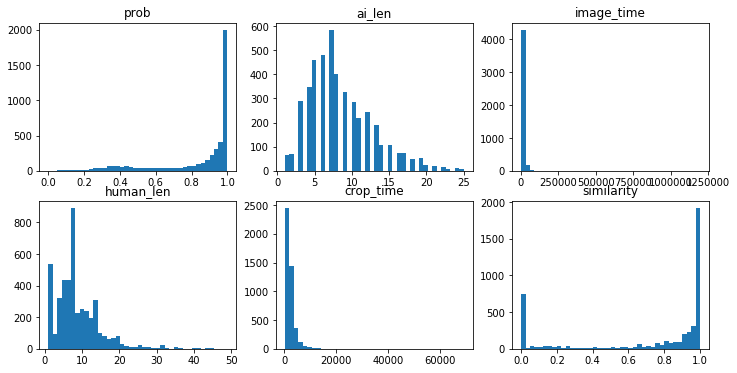

In [9]:
visual_hist(features)

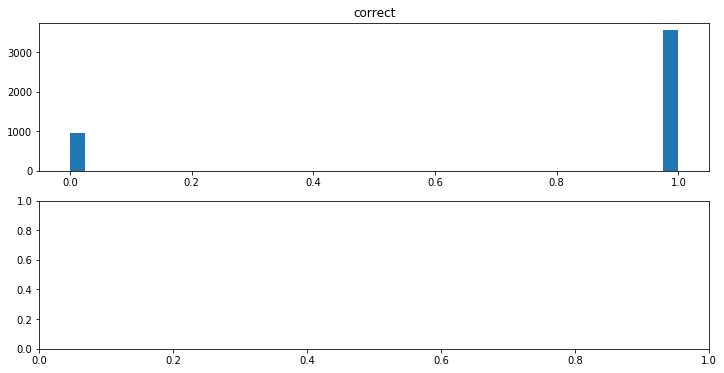

In [11]:
visual_hist(labels)

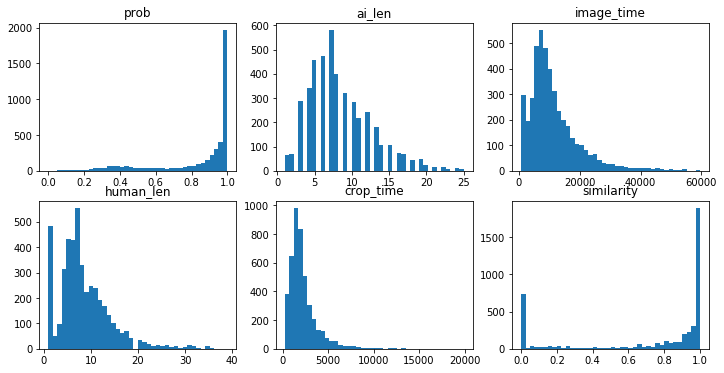

In [18]:
visual_hist(features_remove_fail)

# 데이터 정규화 StandardScaler

In [14]:
def scaler_stand(train, test, columns=None):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    if columns is None:
        train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
        test_scaled = pd.DataFrame(test_scaled, columns=test.columns)
    else :
        train_scaled = pd.DataFrame(train_scaled, columns=columns)
        test_scaled = pd.DataFrame(test_scaled, columns=columns)

    return train_scaled, test_scaled

# 데이터 정규화 RobustScaler

In [15]:
def scaler_robust(train, test, columns=None):
    robustScaler = RobustScaler()
    train_scaled = robustScaler.fit_transform(train)
    test_scaled = robustScaler.transform(test)

    if columns is None:
        train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
        test_scaled = pd.DataFrame(test_scaled, columns=test.columns)

    else :
        train_scaled = pd.DataFrame(train_scaled, columns=columns)
        test_scaled = pd.DataFrame(test_scaled, columns=columns)
    
    return train_scaled, test_scaled

# 데이터 셋 나누기

In [16]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3)

In [17]:
# display(x_train.head())
# print(x_train.shape)
# print(x_test.shape)

# 모델 결과 시각화

In [18]:
def visual_model_performance(loss_and_accuracy, pred_and_label):
    print ("Test Accuracy = " + str(loss_and_accuracy[1]))

    sns.scatterplot(data=pred_and_label, x='index', y='prob', hue='correct')

In [19]:
def visual_training(hist):
    fig, loss_ax = plt.subplots(1,2, figsize=(12,5))

    loss_ax[0].set_title("model loss")
    loss_ax[1].set_title("model accuracy")

    loss_ax[0].plot(hist.history['loss'], 'y', label='train loss')
    loss_ax[0].plot(hist.history['val_loss'], 'r', label='val loss')
    try:
        loss_ax[1].plot(hist.history['accuracy'], 'b', label='train accuracy')
        loss_ax[1].plot(hist.history['val_accuracy'], 'g', label='val accuracy')
    except:
        loss_ax[1].plot(hist.history['acc'], 'b', label='train accuracy')
        loss_ax[1].plot(hist.history['val_acc'], 'g', label='val accuracy')


    loss_ax[0].set_xlabel('epoch')
    loss_ax[1].set_xlabel('epoch')

    loss_ax[0].set_ylabel('loss')
    loss_ax[1].set_ylabel('accuray')

    loss_ax[0].legend(loc='upper left')
    loss_ax[1].legend(loc='upper left')

    plt.show()

# Keras - use features 6

In [20]:
def model_train(features, labels=labels, test_size=0.2, std=None, log_dir='graph'):
    # 모델 정의
    model = Sequential([
        Dense(36, input_shape=(6,)),
        Activation('relu'),
        Dense(64),
        Activation('relu'),
        Dense(12),
        Activation('relu'),
        Dense(1),
        Activation('sigmoid'),
    ])

    # 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # 모델 아키텍처 확인
    model.summary()
    
    if os.path.isdir('./log') is False:
        os.mkdir('./log')
    
    log_dir = './log/' + log_dir
    if os.path.isdir(log_dir) is False:
        os.mkdir(log_dir)
    
    # separate train and test
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size)
    
    # stardard
    if std is not None:
        x_train, x_test = std(x_train, x_test)
    
    # tesor board 
    tb_hist = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
    
    # Training
    hist = model.fit(x_train, y_train, epochs=120, batch_size=256, \
                     validation_data=(x_test, y_test), verbose=0, \
                     callbacks=[tb_hist], 
#                      use_multiprocessing=True
                    )

    # test
    loss_and_accuracy = model.evaluate(x=x_test, y=y_test)
    
    if loss_and_accuracy[1] >= 0.95:
        model.save('upper_95_model.h5')

    y_pred = model.predict(x_test)
    pred_and_label = pd.DataFrame({'index':range(len(y_test)),'prob':y_pred.T[0], 'correct':y_test.correct})
    
    return loss_and_accuracy, pred_and_label, hist

## 정규화 X

In [21]:
loss_and_accuracy, pred_and_label, hist = model_train(features)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 36)                252       
_________________________________________________________________
activation_1 (Activation)    (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2368      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
_________________________________________________________________
activation_3 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

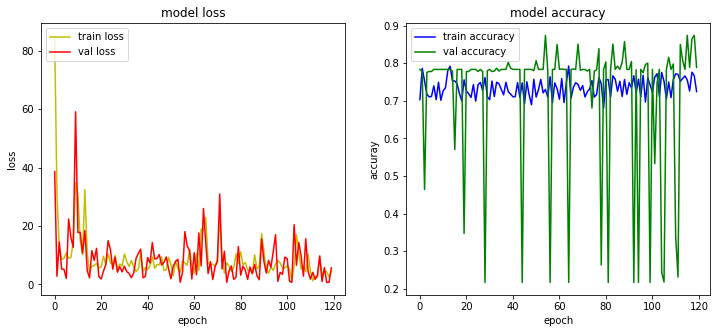

In [22]:
# conda promt에서 tensorboard --logdir=폴더이름(./log/[log_dir]) 실행시 텐서 보드 접속 가능
# tensorboard --logdir=log/graph
# localhost:6006
visual_training(hist)

Test Accuracy = 0.7889502644538879


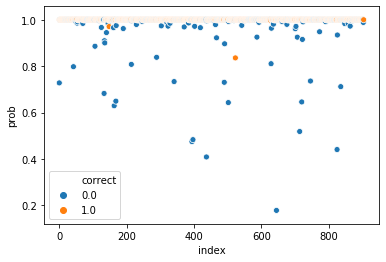

In [23]:
visual_model_performance(loss_and_accuracy, pred_and_label)

## StandardScaler 사용 

In [24]:
stand_loss_and_accuracy, stand_pred_and_label, stand_hist = model_train(features, std=scaler_stand)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 36)                252       
_________________________________________________________________
activation_5 (Activation)    (None, 36)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2368      
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                780       
_________________________________________________________________
activation_7 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

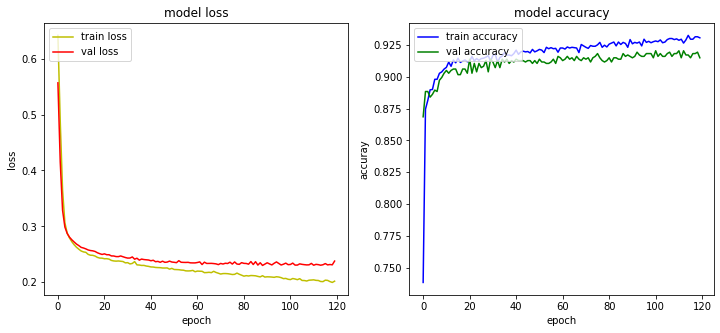

In [25]:
visual_training(stand_hist)

Test Accuracy = 0.9149171113967896


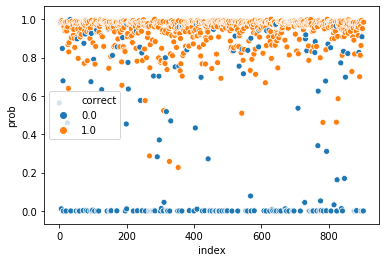

In [26]:
visual_model_performance(stand_loss_and_accuracy, stand_pred_and_label)

## RobustScaler 사용

In [27]:
robust_loss_and_accuracy, robust_pred_and_label, robust_hist = model_train(features, std=scaler_robust)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 36)                252       
_________________________________________________________________
activation_9 (Activation)    (None, 36)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2368      
_________________________________________________________________
activation_10 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                780       
_________________________________________________________________
activation_11 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

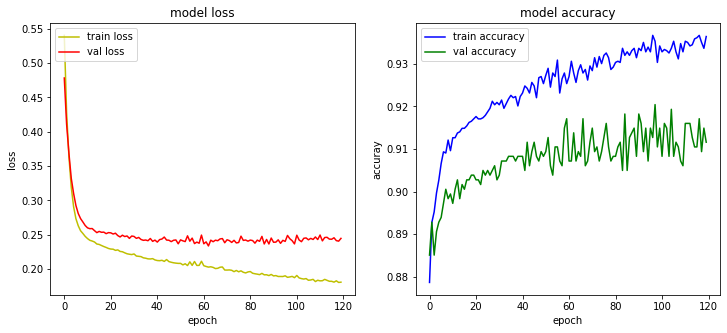

In [28]:
visual_training(robust_hist)

Test Accuracy = 0.9116021990776062


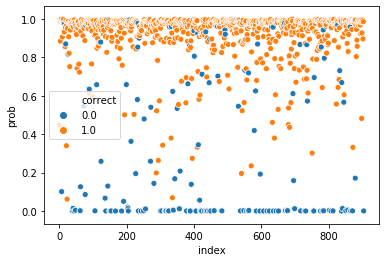

In [29]:
visual_model_performance(robust_loss_and_accuracy, robust_pred_and_label)

# Keras - "prob", "human_len", "ai_len", "image_time", "similarity"

In [30]:
features_5 = total_data[["prob", "human_len", "ai_len", "image_time", "similarity"]]
# x_train, x_test, y_train, y_test = train_test_split(features_5, labels, test_size = 0.2)

In [31]:
def model5_train(features, labels=labels, test_size=0.2, std=None, log_dir='graph'):
    # 모델 정의
    model = Sequential([
        Dense(25, input_shape=(5,)),
        Activation('tanh'),
        Dense(64),
        Activation('sigmoid'),
        Dense(16),
        Activation('relu'),
        Dense(1),
        Activation('sigmoid'),
    ])

    # 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # 모델 아키텍처 확인
    model.summary()
    
    if os.path.isdir('./log') is False:
        os.mkdir('./log')
    
    log_dir = './log/' + log_dir
    if os.path.isdir(log_dir) is False:
        os.mkdir(log_dir)
    
    # separate train and test
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size)
    
    # stardard
    if std is not None:
        x_train, x_test = std(x_train, x_test)
    
    # tesor board 
    tb_hist = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
    
    # Training
    hist = model.fit(x_train, y_train, epochs=1500, batch_size=128,\
                     validation_data=(x_test, y_test), verbose=0, \
                     callbacks=[tb_hist], 
                     # use_multiprocessing=True
                    )

    # test
    loss_and_accuracy = model.evaluate(x=x_test, y=y_test)

    if loss_and_accuracy[1] >= 0.94:
        model.save('upper_94_model.h5')
    
    y_pred = model.predict(x_test)
    pred_and_label = pd.DataFrame({'index':range(len(y_test)),'prob':y_pred.T[0], 'correct':y_test.correct})
    
    return loss_and_accuracy, pred_and_label, hist

## 정규화 X

In [32]:
loss_and_accuracy, pred_and_label, hist = model5_train(features_5, log_dir="feature5_no_stand")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 25)                150       
_________________________________________________________________
activation_13 (Activation)   (None, 25)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                1664      
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_15 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

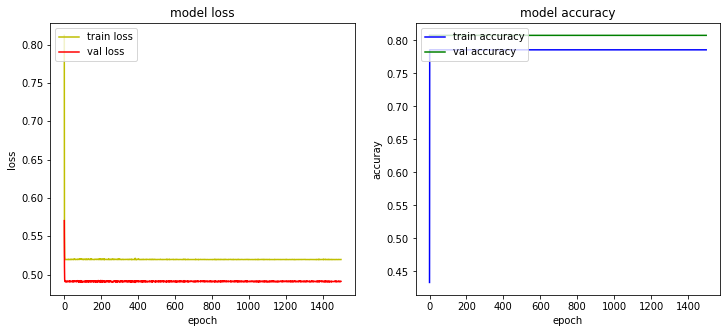

In [33]:
visual_training(hist)

Test Accuracy = 0.8077347874641418


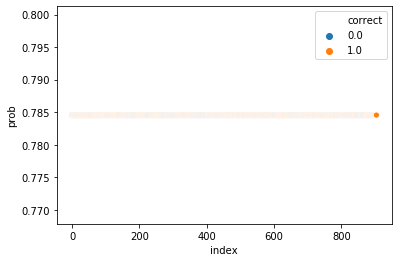

In [34]:
visual_model_performance(loss_and_accuracy, pred_and_label)

## StandardScaler 사용 

In [40]:
stand_loss_and_accuracy, stand_pred_and_label, stand_hist = model5_train(features_5, std=scaler_stand, log_dir="feature5_stand")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 25)                150       
_________________________________________________________________
activation_17 (Activation)   (None, 25)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                1664      
_________________________________________________________________
activation_18 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_19 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
__________

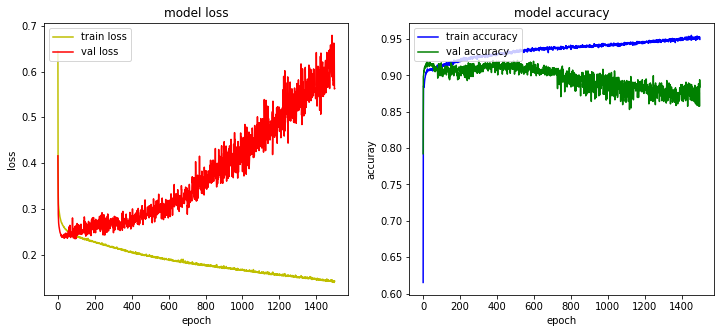

In [41]:
visual_training(stand_hist)

Test Accuracy = 0.8839779005524862


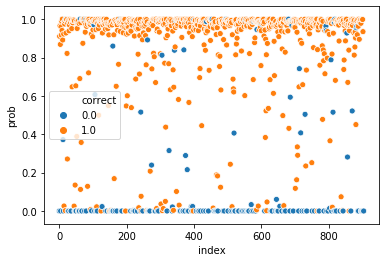

In [42]:
visual_model_performance(stand_loss_and_accuracy, stand_pred_and_label)

# RobustScaler 사용

In [43]:
robust_loss_and_accuracy, robust_pred_and_label, robust_hist = model5_train(features_5, std=scaler_robust, log_dir="feature5_robust")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 25)                150       
_________________________________________________________________
activation_21 (Activation)   (None, 25)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                1664      
_________________________________________________________________
activation_22 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_23 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
__________

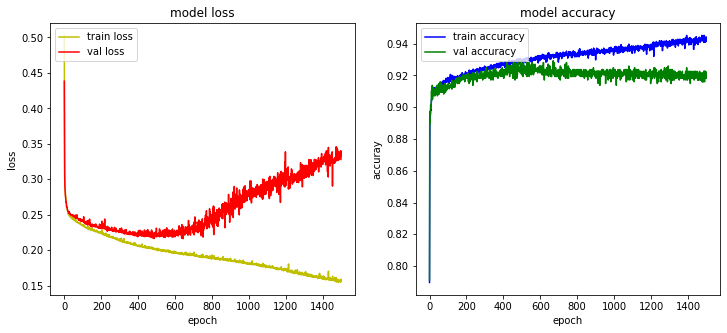

In [44]:
visual_training(robust_hist)

Test Accuracy = 0.918232044198895


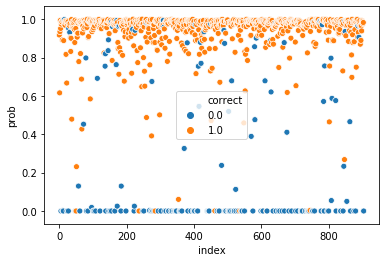

In [45]:
visual_model_performance(robust_loss_and_accuracy, robust_pred_and_label)

In [46]:
robust_loss_and_accuracy, robust_pred_and_label, robust_hist = model5_train(features_5, std=scaler_robust, log_dir="feature5_robust")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 25)                150       
_________________________________________________________________
activation_25 (Activation)   (None, 25)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                1664      
_________________________________________________________________
activation_26 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_27 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
__________

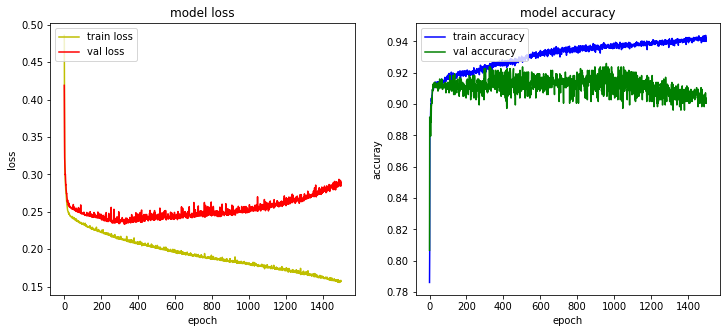

In [47]:
visual_training(robust_hist)

Test Accuracy = 0.9005524861878453


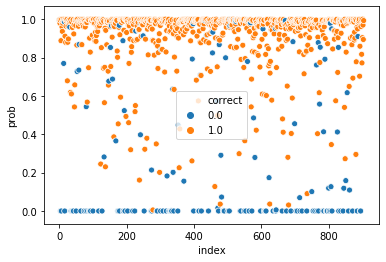

In [48]:
visual_model_performance(robust_loss_and_accuracy, robust_pred_and_label)

In [49]:
robust_loss_and_accuracy= [0 ,0]

In [ ]:
while robust_loss_and_accuracy[1] < 0.94:
    robust_loss_and_accuracy, robust_pred_and_label, robust_hist = model5_train(features_5, std=scaler_robust, log_dir="feature5_robust")
    print(f"Test accuracy: {robust_loss_and_accuracy[1]}")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 25)                150       
_________________________________________________________________
activation_29 (Activation)   (None, 25)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1664      
_________________________________________________________________
activation_30 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_31 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 17        
__________

In [ ]:
visual_training(robust_hist)

In [ ]:
visual_model_performance(robust_loss_and_accuracy, robust_pred_and_label)

# Res NET

In [ ]:
# # 모델 정의
# model = Sequential([
#     Dense(36, input_shape=(6,)),
#     Activation('relu'),
#     Dense(64),
#     Activation('relu'),
#     Dense(12),
#     Activation('relu'),
#     Dense(1),
#     Activation('sigmoid'),
# ])

# # 컴파일
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # 모델 아키텍처 확인
# model.summary()

# # Training
# model.fit(x_train, y_train, epochs=120, batch_size=16)

# # test
# preds = model.evaluate(x=x_test, y=y_test)

# y_pred = model.predict(x_test)
# pre_and_test = pd.DataFrame({'index':range(len(y_test)),'prob':y_pred.T[0], 'correct':y_test.correct})

# sns.scatterplot(data=pre_and_test, x='index', y='prob', hue='correct')

In [ ]:
features = features[['prob', 'human_len', 'ai_len', 'image_time', 'similarity']]

In [ ]:
def plt_scores(N, accuracy, recall, precision, f1):
    fig, ax = plt.subplots(figsize=(12,6))

    ax.plot(range(N), accuracy)
    ax.plot(range(N), recall)
    ax.plot(range(N), precision)
    ax.plot(range(N), f1)
    ax.legend(['accuracy', 'recall', 'precision', 'f1_score'])
    plt.show()
    
    print(f"평균 정확도: {np.mean(accuracy)}")
    print(f"최대 정확도: {max(accuracy)}, 인덱스: {accuracy.index(max(accuracy))}")

# LogisticRegression

In [ ]:
# train set, test set 으로 분리한 후 학습하는 과정을 N번 반복한다
# 그런다음 각 metric을 저장하고, 이를 시각화하여 최댓값과 최소값을 비교한다
accuracy = []
recall = []
precision = []
f1 = []
N = 500
for i in range(N):
    # 전체 데이터셋을 train set과 test 셋으로 분리한다
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)
    
    x_train, x_test = scaler_stand(x_train, x_test)

    
    # Logistic Regression 모델 생성
    LR_model = LogisticRegression()
    LR_model.fit(x_train, y_train)

    y_pred = LR_model.predict(x_test)
    
    accuracy.append(accuracy_score(y_pred, y_test.correct))
    recall.append(recall_score(y_pred, y_test.correct))
    precision.append(precision_score(y_pred, y_test.correct))
    f1.append(f1_score(y_pred, y_test.correct))
    

In [ ]:
plt_scores(N, accuracy, recall, precision, f1)

# KNN

In [ ]:
accuracy = []
recall = []
precision = []
f1 = []
N = 500
for i in range(1, N+1):
    x_train, x_test, y_train, y_test = train_test_split(features_5, labels, test_size = 0.2)
    
    x_train, x_test = scaler_robust(x_train, x_test)

    
    ml = KNeighborsClassifier(n_neighbors=25, p=2, metric="minkowski")
    ml.fit(x_train, y_train)
    y_pred = ml.predict(x_test)
    
    accuracy.append(accuracy_score(y_pred, y_test.correct))
    recall.append(recall_score(y_pred, y_test.correct))
    precision.append(precision_score(y_pred, y_test.correct))
    f1.append(f1_score(y_pred, y_test.correct))

In [ ]:
plt_scores(N, accuracy, recall, precision, f1)

# Decision Tree

In [ ]:
accuracy = []
recall = []
precision = []
f1 = []
N = 500
for i in range(1, N+1):
    x_train, x_test, y_train, y_test = train_test_split(features_5, labels, test_size = 0.2)
    
    x_train, x_test = scaler_robust(x_train, x_test)
    
    dTreeAll = DecisionTreeClassifier(random_state=0, max_depth=4)
    dTreeAll.fit(x_train, y_train)
    y_pred = dTreeAll.predict(x_test)

    accuracy.append(accuracy_score(y_pred, y_test.correct))
    recall.append(recall_score(y_pred, y_test.correct))
    precision.append(precision_score(y_pred, y_test.correct))
    f1.append(f1_score(y_pred, y_test.correct))

In [ ]:
plt_scores(N, accuracy, recall, precision, f1)